# GloVE

Let's work on implementation of GloVE.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## 1. Load data (Real-world corpus: NLTK Reuters)

We train GloVe on the **Reuters-21578** newswire corpus distributed with the **NLTK** library (`nltk.corpus.reuters`).

**Dataset credit:** Reuters-21578 corpus as packaged by NLTK. Please cite NLTK and Reuters-21578 in your report/README.


In [2]:
import nltk
from nltk.corpus import reuters

# Download once (safe to call repeatedly)
nltk.download('reuters')

def preprocess_tokens(tokens):
    """Lowercase, keep alphabetic tokens only."""
    return [t.lower() for t in tokens if t.isalpha()]

def load_reuters_corpus(categories=None, max_docs=None):
    """
    Returns: list[list[str]] where each inner list is a tokenized document.

    categories: list[str] | None
      - If provided, only use these Reuters topic categories (e.g., ['crude','grain']).
    max_docs: int | None
      - Optional cap for faster experiments.
    """
    if categories is None:
        fileids = reuters.fileids()
    else:
        fileids = reuters.fileids(categories)

    if max_docs is not None:
        fileids = fileids[:max_docs]

    docs = [preprocess_tokens(reuters.words(fid)) for fid in fileids]
    # remove empty docs
    docs = [d for d in docs if len(d) >= 3]
    return docs

# Default: a small subset for quick iteration; increase max_docs for better quality
corpus = load_reuters_corpus(categories=['crude', 'grain', 'money-fx'], max_docs=2000)
len(corpus), corpus[0][:20]


[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\Windows\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


(1854,
 ['china',
  'daily',
  'says',
  'vermin',
  'eat',
  'pct',
  'grain',
  'stocks',
  'a',
  'survey',
  'of',
  'provinces',
  'and',
  'seven',
  'cities',
  'showed',
  'vermin',
  'consume',
  'between',
  'seven'])

The Reuters corpus is already tokenized by NLTK. `corpus` is a list of token lists (one per document).

In [3]:
#get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))
vocab

['committal',
 'tend',
 'fetched',
 'licence',
 'giordano',
 'comprehension',
 'accumulating',
 'definite',
 'oregon',
 'georgia',
 'murphy',
 'locals',
 'allotted',
 'washita',
 'grounds',
 'bound',
 'barite',
 'budget',
 'linkup',
 'steep',
 'milo',
 'francaise',
 'irreversible',
 'kingdom',
 'concern',
 'someway',
 'demonstrate',
 'benefits',
 'inra',
 'ne',
 'howard',
 'dresdner',
 'platform',
 'artillery',
 'usual',
 'helicopter',
 'pickles',
 'accrued',
 'montano',
 'schlick',
 'degrees',
 'investigated',
 'benson',
 'satisfactory',
 'downtrend',
 'isn',
 'j',
 'soyb',
 'baseless',
 'fragmented',
 'safer',
 'emigration',
 'stiffer',
 'oversee',
 'katharina',
 'caucasus',
 'luck',
 'millions',
 'utilities',
 'capturing',
 'boosted',
 'subscription',
 'p',
 'discharges',
 'yes',
 'insistence',
 'indefinite',
 'like',
 'omer',
 'eating',
 'prisoner',
 'amauligak',
 'segment',
 'deviations',
 'negotiators',
 'going',
 'treatment',
 'hanes',
 'sab',
 'guinea',
 'through',
 'gomes',
 '

In [4]:
#numericalization
word2index = {w: i for i, w in enumerate(vocab)}
print(word2index)

{'committal': 0, 'tend': 1, 'fetched': 2, 'licence': 3, 'giordano': 4, 'comprehension': 5, 'accumulating': 6, 'definite': 7, 'oregon': 8, 'georgia': 9, 'murphy': 10, 'locals': 11, 'allotted': 12, 'washita': 13, 'grounds': 14, 'bound': 15, 'barite': 16, 'budget': 17, 'linkup': 18, 'steep': 19, 'milo': 20, 'francaise': 21, 'irreversible': 22, 'kingdom': 23, 'concern': 24, 'someway': 25, 'demonstrate': 26, 'benefits': 27, 'inra': 28, 'ne': 29, 'howard': 30, 'dresdner': 31, 'platform': 32, 'artillery': 33, 'usual': 34, 'helicopter': 35, 'pickles': 36, 'accrued': 37, 'montano': 38, 'schlick': 39, 'degrees': 40, 'investigated': 41, 'benson': 42, 'satisfactory': 43, 'downtrend': 44, 'isn': 45, 'j': 46, 'soyb': 47, 'baseless': 48, 'fragmented': 49, 'safer': 50, 'emigration': 51, 'stiffer': 52, 'oversee': 53, 'katharina': 54, 'caucasus': 55, 'luck': 56, 'millions': 57, 'utilities': 58, 'capturing': 59, 'boosted': 60, 'subscription': 61, 'p': 62, 'discharges': 63, 'yes': 64, 'insistence': 65, 'i

In [5]:
#vocab size
voc_size = len(vocab)
print(voc_size)

12479


In [6]:
#append UNK
vocab.append('<UNK>')

In [7]:
vocab

['committal',
 'tend',
 'fetched',
 'licence',
 'giordano',
 'comprehension',
 'accumulating',
 'definite',
 'oregon',
 'georgia',
 'murphy',
 'locals',
 'allotted',
 'washita',
 'grounds',
 'bound',
 'barite',
 'budget',
 'linkup',
 'steep',
 'milo',
 'francaise',
 'irreversible',
 'kingdom',
 'concern',
 'someway',
 'demonstrate',
 'benefits',
 'inra',
 'ne',
 'howard',
 'dresdner',
 'platform',
 'artillery',
 'usual',
 'helicopter',
 'pickles',
 'accrued',
 'montano',
 'schlick',
 'degrees',
 'investigated',
 'benson',
 'satisfactory',
 'downtrend',
 'isn',
 'j',
 'soyb',
 'baseless',
 'fragmented',
 'safer',
 'emigration',
 'stiffer',
 'oversee',
 'katharina',
 'caucasus',
 'luck',
 'millions',
 'utilities',
 'capturing',
 'boosted',
 'subscription',
 'p',
 'discharges',
 'yes',
 'insistence',
 'indefinite',
 'like',
 'omer',
 'eating',
 'prisoner',
 'amauligak',
 'segment',
 'deviations',
 'negotiators',
 'going',
 'treatment',
 'hanes',
 'sab',
 'guinea',
 'through',
 'gomes',
 '

In [8]:
word2index['<UNK>'] = 0

In [9]:
#just in case we need to use
index2word = {v:k for k, v in word2index.items()} 

## 2. Build Co-occurence Matrix X

Here, we count the co-occurrence of two words within a configurable **window size**.

> Requirement: window size must be dynamically adjustable during training.

We will use **window size = 2 by default** and provide a `window_schedule(epoch)` function so you can change it while training.

In [10]:
from collections import Counter

X_i = Counter(flatten(corpus))
X_i

Counter({'the': 21152,
         'to': 10496,
         'of': 9233,
         'in': 7661,
         'said': 6731,
         'and': 6657,
         'a': 6202,
         's': 5005,
         'for': 3521,
         'mln': 2723,
         'u': 2587,
         'on': 2578,
         'that': 2504,
         'at': 2413,
         'oil': 2329,
         'it': 2156,
         'is': 2110,
         'by': 1961,
         'from': 1959,
         'he': 1874,
         'pct': 1865,
         'was': 1831,
         'be': 1715,
         'with': 1606,
         'as': 1496,
         'will': 1454,
         'dlrs': 1434,
         'its': 1427,
         'would': 1417,
         'bank': 1376,
         'market': 1321,
         'not': 1316,
         'year': 1248,
         'tonnes': 1243,
         'an': 1242,
         'has': 1235,
         'but': 1230,
         'this': 1222,
         'dollar': 1194,
         'last': 1054,
         'were': 1009,
         'have': 1009,
         'wheat': 1008,
         'are': 995,
         'had': 919,
   

In [11]:
from collections import defaultdict

def build_cooccurrence(corpus, word2index, window_size=2, distance_weighting=True):
    """
    Build (i,j)->X_ij co-occurrence counts for GloVe.

    - window_size: symmetric window on each side of the center word
    - distance_weighting: if True, add 1/d for context at distance d (common GloVe practice)

    Returns:
      X_ij: dict[(str,str), float] for word pairs (word_i, word_j)
      skip_grams: list[(str,str)] (unweighted, for sampling batches)
    """
    X_ij = defaultdict(float)
    skip_grams = []

    for doc in corpus:
        n = len(doc)
        for i, center in enumerate(doc):
            if center not in word2index:
                center = '<UNK>'
            start = max(0, i - window_size)
            end = min(n, i + window_size + 1)
            for j in range(start, end):
                if j == i:
                    continue
                context = doc[j]
                if context not in word2index:
                    context = '<UNK>'
                d = abs(j - i)
                w = (1.0 / d) if (distance_weighting and d > 0) else 1.0
                X_ij[(center, context)] += w
                skip_grams.append((center, context))

    return dict(X_ij), skip_grams

# ---- Window schedule (dynamic window during training) ----

def window_schedule(epoch, default_window=2):
    """
    Example schedule: start at default_window and increase every 1000 epochs up to 5.
    You can replace this with any schedule you like.
    """
    return min(5, default_window + epoch // 1000)

# Build co-occurrence with default window=2 (required default)
current_window = window_schedule(epoch=0, default_window=2)
X_ik, skip_grams = build_cooccurrence(corpus, word2index, window_size=current_window)
len(skip_grams), list(X_ik.items())[:3]


(1363788,
 [(('china', 'daily'), 16.5),
  (('china', 'says'), 3.0),
  (('daily', 'china'), 16.5)])

`X_ik` now stores (center, context) → co-occurrence value (possibly distance-weighted).

### Weighting function

GloVe includes a weighting function to scale down too frequent words.

<img src = "../figures/glove_weighting_func.png" width=400>

In [12]:
def weighting(w_i, w_j, X_ik):
    
    #check whether the co-occurences between w_i and w_j is available
    try:
        x_ij = X_ik[(w_i, w_j)]
        #if not exist, then set to 1 "laplace smoothing"
    except:
        x_ij = 1
        
    #set xmax
    x_max = 100
    #set alpha
    alpha = 0.75
    
    #if co-ocurrence does not exceeed xmax, then just multiply with some alpha
    if x_ij < x_max:
        result = (x_ij / x_max)**alpha
    #otherwise, set to 1
    else:
        result = 1
    
    return result

In [13]:
# Add +1 for numerical stability (avoids log(0)) and precompute weighting values

X_ik_stable = {(wi,wj): (x + 1.0) for (wi,wj), x in X_ik.items()}

# ensure symmetry is present (optional but common)
for (wi,wj), x in list(X_ik_stable.items()):
    if (wj,wi) not in X_ik_stable:
        X_ik_stable[(wj,wi)] = x

X_ik = X_ik_stable

weighting_dic = {}
for (wi, wj), x_ij in X_ik.items():
    weighting_dic[(wi, wj)] = weighting(wi, wj, X_ik)

len(X_ik), list(weighting_dic.items())[:3]


(452435,
 [(('china', 'daily'), 0.2705693114928809),
  (('china', 'says'), 0.08944271909999159),
  (('daily', 'china'), 0.2705693114928809)])

## 3. Prepare train data

In [14]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    random_inputs, random_labels, random_coocs, random_weightings = [], [], [], []
    
    #convert our skipgrams to id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    #randomly choose indexes based on batch size
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False)
    
    #get the random input and labels
    for index in random_index:
        random_inputs.append([skip_grams_id[index][0]])
        random_labels.append([skip_grams_id[index][1]])
        #coocs
        pair = skip_grams[index] #e.g., ('banana', 'fruit')
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
    
        #weightings
        w_val = weighting_dic[pair]
        random_weightings.append([w_val])
        
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

### Testing the method

In [15]:
batch_size = 2
x, y, cooc, weighting_batch_np = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)

In [16]:
x

array([[1846],
       [4376]])

In [17]:
y

array([[10745],
       [ 9428]])

In [18]:
cooc

array([[1.5040774 ],
       [0.91629073]])

In [19]:
weighting_batch_np

array([[0.09770333],
       [0.06287167]])

## 4. Model

<img src ="../figures/glove.png" width=400>

In [20]:
class Glove(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Glove, self).__init__()
        self.center_embedding  = nn.Embedding(voc_size, emb_size)
        self.outside_embedding = nn.Embedding(voc_size, emb_size)
        
        self.center_bias       = nn.Embedding(voc_size, 1) 
        self.outside_bias      = nn.Embedding(voc_size, 1)
    
    def forward(self, center, outside, coocs, weighting):
        center_embeds  = self.center_embedding(center) #(batch_size, 1, emb_size)
        outside_embeds = self.outside_embedding(outside) #(batch_size, 1, emb_size)
        
        center_bias    = self.center_bias(center).squeeze(1)
        target_bias    = self.outside_bias(outside).squeeze(1)
        
        inner_product  = outside_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1)
        
        loss = weighting * torch.pow(inner_product + center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

In [21]:
#test our system
voc_size = len(vocab)
emb_size = 2
model = Glove(voc_size, emb_size)

In [22]:
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)
cooc_tensor = torch.FloatTensor(cooc)
weighting_tensor = torch.FloatTensor(weighting_batch_np)

In [23]:
loss = model(x_tensor, y_tensor, cooc_tensor, weighting_tensor)

In [24]:
loss

tensor(0.6731, grad_fn=<SumBackward0>)

## 5. Training

In [25]:
batch_size     = 10 # mini-batch size
embedding_size = 2 #so we can later plot
model          = Glove(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [27]:
import time

# Training
num_epochs = 5000
prev_window = None

for epoch in range(num_epochs):
    start = time.time()

    # --- dynamically adjust window size during training (requirement) ---
    current_window = window_schedule(epoch, default_window=2)
    if current_window != prev_window:
        X_ik, skip_grams = build_cooccurrence(corpus, word2index, window_size=current_window)
        X_ik = {(wi,wj): (x + 1.0) for (wi,wj), x in X_ik.items()}
        weighting_dic = {(wi,wj): weighting(wi, wj, X_ik) for (wi,wj) in X_ik.keys()}
        prev_window = current_window

    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch)
    target_batch = torch.LongTensor(target_batch)
    cooc_batch   = torch.FloatTensor(cooc_batch)
    weighting_batch = torch.FloatTensor(weighting_batch)

    optimizer.zero_grad()
    loss = model(input_batch, target_batch, cooc_batch, weighting_batch)
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"epoch={epoch:5d}  window={current_window}  loss={loss.item():.4f}  time={(time.time()-start):.3f}s")


epoch=    0  window=2  loss=73.6743  time=2.365s
epoch=  200  window=2  loss=30.3450  time=0.375s
epoch=  400  window=2  loss=43.1930  time=0.379s
epoch=  600  window=2  loss=87.7056  time=0.375s
epoch=  800  window=2  loss=89.4265  time=0.346s
epoch= 1000  window=3  loss=83.1473  time=2.871s
epoch= 1200  window=3  loss=78.2846  time=0.534s
epoch= 1400  window=3  loss=43.0020  time=0.541s
epoch= 1600  window=3  loss=45.1137  time=0.733s
epoch= 1800  window=3  loss=85.8237  time=0.572s
epoch= 2000  window=4  loss=9.2703  time=3.928s
epoch= 2200  window=4  loss=39.2584  time=0.727s
epoch= 2400  window=4  loss=49.9763  time=0.716s
epoch= 2600  window=4  loss=39.2133  time=0.729s
epoch= 2800  window=4  loss=41.5518  time=0.809s
epoch= 3000  window=5  loss=145.4725  time=5.001s
epoch= 3200  window=5  loss=43.4728  time=0.870s
epoch= 3400  window=5  loss=26.7067  time=0.938s
epoch= 3600  window=5  loss=14.9138  time=0.915s
epoch= 3800  window=5  loss=53.2541  time=0.854s
epoch= 4000  window=

## 6. Plotting the embeddings

In [28]:
#list of vocabs
vocab[:10]

['committal',
 'tend',
 'fetched',
 'licence',
 'giordano',
 'comprehension',
 'accumulating',
 'definite',
 'oregon',
 'georgia']

In [29]:
word = vocab[0]

In [30]:
#numericalization
id = word2index[word]
id

0

In [31]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [32]:
#get the embedding by averaging
v_embed = model.center_embedding(id_tensor)
u_embed = model.outside_embedding(id_tensor)

v_embed, u_embed

(tensor([[-0.0612,  0.5792]], grad_fn=<EmbeddingBackward0>),
 tensor([[-2.0163, -0.8928]], grad_fn=<EmbeddingBackward0>))

In [33]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed

tensor([[-1.0388, -0.1568]], grad_fn=<DivBackward0>)

In [34]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.center_embedding(id_tensor)
    u_embed = model.outside_embedding(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

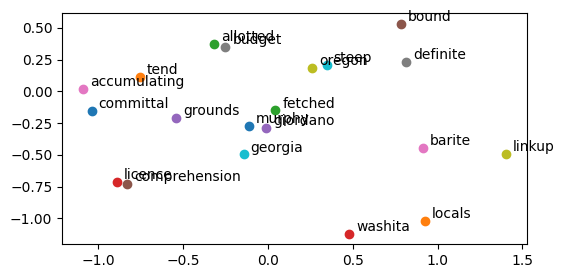

In [35]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 7. Cosine similarity



In [36]:
vocab

['committal',
 'tend',
 'fetched',
 'licence',
 'giordano',
 'comprehension',
 'accumulating',
 'definite',
 'oregon',
 'georgia',
 'murphy',
 'locals',
 'allotted',
 'washita',
 'grounds',
 'bound',
 'barite',
 'budget',
 'linkup',
 'steep',
 'milo',
 'francaise',
 'irreversible',
 'kingdom',
 'concern',
 'someway',
 'demonstrate',
 'benefits',
 'inra',
 'ne',
 'howard',
 'dresdner',
 'platform',
 'artillery',
 'usual',
 'helicopter',
 'pickles',
 'accrued',
 'montano',
 'schlick',
 'degrees',
 'investigated',
 'benson',
 'satisfactory',
 'downtrend',
 'isn',
 'j',
 'soyb',
 'baseless',
 'fragmented',
 'safer',
 'emigration',
 'stiffer',
 'oversee',
 'katharina',
 'caucasus',
 'luck',
 'millions',
 'utilities',
 'capturing',
 'boosted',
 'subscription',
 'p',
 'discharges',
 'yes',
 'insistence',
 'indefinite',
 'like',
 'omer',
 'eating',
 'prisoner',
 'amauligak',
 'segment',
 'deviations',
 'negotiators',
 'going',
 'treatment',
 'hanes',
 'sab',
 'guinea',
 'through',
 'gomes',
 '

In [38]:
#let's try similarity between first and second, and second and third
japan          = get_embed('japan')
fruit        = get_embed('fruit')
animal       = get_embed('animal')

In [40]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim
    
print(f"japan vs. fruit: ",        cos_sim(japan, fruit))
print(f"japan vs. animal: ",       cos_sim(japan, animal))
print(f"japan vs. japan: ",          cos_sim(japan, japan))

japan vs. fruit:  0.9257473684240026
japan vs. animal:  0.701974463750928
japan vs. japan:  1.0


In [41]:
#scipy version
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

print(f"japan vs. fruit: ",        cos_sim(japan, fruit))
print(f"japan vs. animal: ",       cos_sim(japan, animal))
print(f"japan vs. japan: ",          cos_sim(japan, japan))

japan vs. fruit:  0.9257473684240024
japan vs. animal:  0.701974463750928
japan vs. japan:  1.0


## Export learned vectors
We export embeddings in word2vec text format so they can be loaded by Gensim for similarity queries.

In [43]:
import numpy as np

# Combine center + outside embeddings (common for GloVe usage)
W = model.center_embedding.weight.detach().cpu().numpy()
W_tilde = model.outside_embedding.weight.detach().cpu().numpy()
vectors = W + W_tilde

out_path = "reuters_glove_vectors.txt"
with open(out_path, "w", encoding="utf-8") as f:
    # header: vocab_size embedding_dim
    f.write(f"{len(vocab)} {vectors.shape[1]}\n")
    
    for w, i in word2index.items():
        vec = " ".join(f"{x:.6f}" for x in vectors[i])
        f.write(f"{w} {vec}\n")

out_path


'reuters_glove_vectors.txt'

## 7. Export vectors (for use in Gensim)

We export the learned vectors in **word2vec text** format so you can load them with `gensim.models.KeyedVectors` and run similarity queries.


In [44]:
import numpy as np

def export_glove_word2vec_text(model, index2word, out_path='glove_reuters_vectors.txt'):
    # Export (W + W_tilde) vectors to word2vec text format.
    W = model.center_embedding.weight.detach().cpu().numpy()
    W_tilde = model.outside_embedding.weight.detach().cpu().numpy()
    V = W + W_tilde

    vocab_size, dim = V.shape
    with open(out_path, 'w', encoding='utf-8') as f:
        f.write(f"{vocab_size} {dim}\n")
        for i in range(vocab_size):
            w = index2word.get(i)
            if w is None:
                continue
            vec = ' '.join(map(str, V[i].tolist()))
            f.write(f"{w} {vec}\n")

    print('Saved:', out_path)

export_glove_word2vec_text(model, index2word, out_path='glove_reuters_vectors.txt')


Saved: glove_reuters_vectors.txt
